## Importing and Initializing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
from scipy.ndimage import convolve

In [2]:
data_dir = "/home/iiserb/Desktop/CV_Project/Yale_face_database"
sample_img = "/home/iiserb/Desktop/CV_Project/Yale_face_database/subject15.centerlight"
normalized_dir = "/home/iiserb/Desktop/CV_Project/normalized_data"

In [3]:
subject = []
emotions = ['centerlight', 'happy', 'leftlight', 'glasses', 'normal',
                'rightlight', 'sad', 'sleepy', 'surprised', 'wink','noglasses']
for i in range (1,16):
  subject.append(f"subject0{i}")

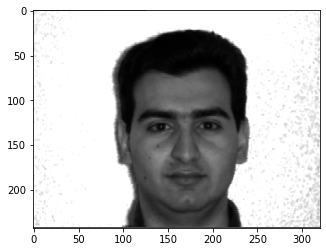

In [4]:
img = Image.open(sample_img)
plt.imshow(img, cmap="gray")
plt.show()

In [5]:
type(img)

PIL.GifImagePlugin.GifImageFile

In [6]:
img_ndarray = np.asarray(img)
img_ndarray.shape

(243, 320)

In [7]:
(img_ndarray.min(),img_ndarray.max())

(0, 255)

In [8]:
def get_array(subject_id, expression, directory):
    target_filename = f"subject{subject_id}.{expression}"

    for filename in os.listdir(directory):
        if filename == target_filename:
            filepath = os.path.join(directory, filename)
            try:
                img = Image.open(filepath)
                img_ndarray = np.asarray(img)
                return img_ndarray

            except IOError:
                print(f"Cannot open file: {filepath}")

    print(f"File {target_filename} not found in directory.")
    return None

# Image Visualization and Preprocessing

1. Look at the data
2. Distribution of images and expressions.
3. Image Histogram (for pixel values)
4. Check if all of them are of same size. If not, resize.


## Data Visualization

In [9]:
def show_data(subject_id):
    # Initialize list to store images.
    images = []
     # Load images for the specified subject
    for emotion in emotions:
        filename = f'subject{subject_id}.{emotion}'
        filepath = os.path.join(data_dir, filename)
        try:
            img = Image.open(filepath)  #Data type of img: PIL.GifImagePlugin.GifImageFile
            images.append(img)
        except FileNotFoundError:
            print(f"File not found: {filepath}")

    # Define the grid size for visualization
    grid_size = (3,4)

    # Create a new figure
    plt.figure(figsize=(15,12))

    # Plot each image
    for i, img in enumerate(images):
        plt.subplot(grid_size[0], grid_size[1], i + 1)
        plt.imshow(img, cmap='gray')  # Show image in grayscale
        plt.axis('off')
        plt.title(f'{emotions[i]}', fontsize=10)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.suptitle(f"Images of Subject {subject_id}", fontsize=16)
    plt.subplots_adjust(top=0.9)  # Adjust title position
    plt.show()


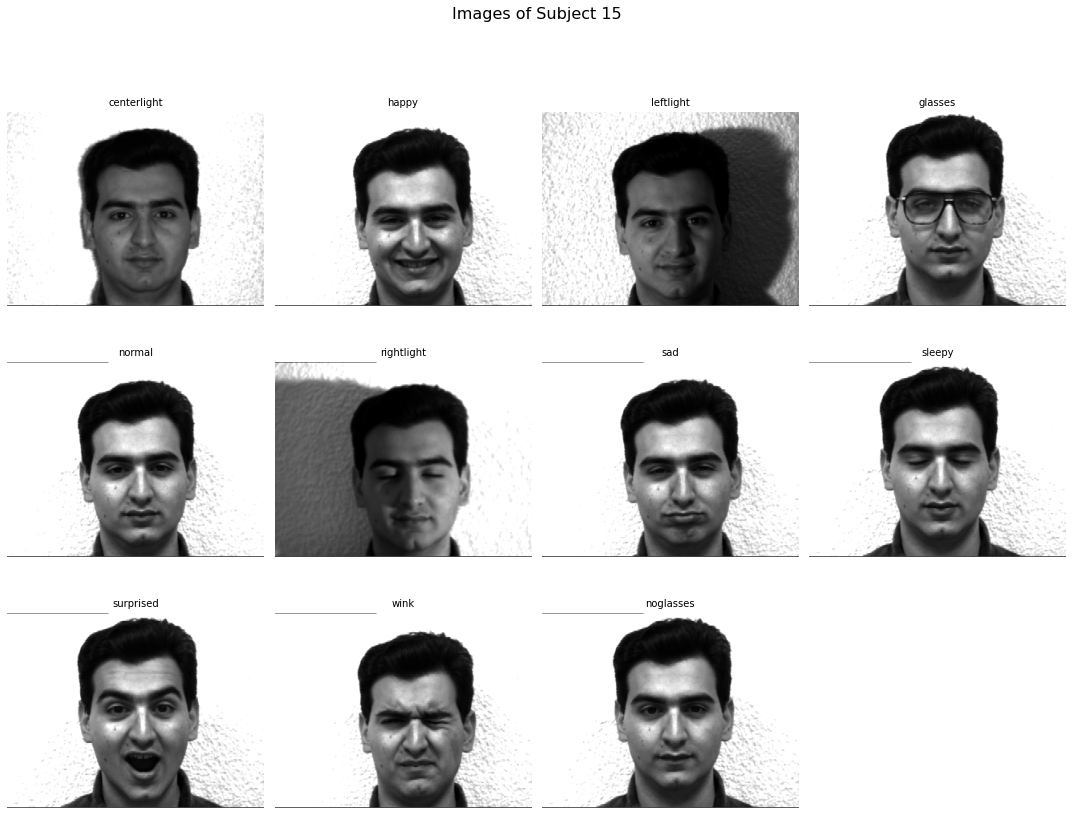

In [10]:
show_data(subject_id='15')

## Distribution of data


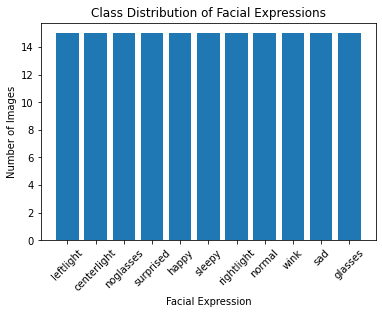

In [11]:
expression_counts = {}

for filename in os.listdir(data_dir):
    expression = filename.split('.')[1]
    if expression in expression_counts:
        expression_counts[expression] += 1
    else:
        expression_counts[expression] = 1


plt.bar(expression_counts.keys(), expression_counts.values())
plt.xlabel('Facial Expression')
plt.ylabel('Number of Images')
plt.title('Class Distribution of Facial Expressions')
plt.xticks(rotation=45)
plt.show()


## Check if all the images are of same size

In [12]:
def hasSameShape(directory):

    shape = set()  # Use a set to store unique sizes

    # Iterate over files in the directory
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        try:
            with Image.open(filepath) as img:
                img = np.asarray(img)
                shape.add(img.shape)  # Add size (width, height) to the set
        except IOError:
            print(f"Cannot open file: {filepath}")

    if len(shape) == 1:  #since sizes is a set, it will not store duplicates.
        # All images have the same size
        sh = shape.pop()  # Get the unique size
        print(f"All the images are of shape. \nThe shape is {sh}")
    else:
        # Images have different sizes
        return False, None



In [13]:
hasSameShape(data_dir)

All the images are of shape. 
The shape is (243, 320)


## Normalization

Normalization helps improve the performance and convergence speed of machine learning algorithms.
Normalizing the pixel values to [0,1]

In [14]:
def normalize_image(directory, output_directory):

    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        try:
            with Image.open(filepath) as img:
                img_ndarray = np.asarray(img, dtype=np.float32)
                img_ndarray = img_ndarray.copy()
                img_ndarray /= 255.0

            output_filepath = os.path.join(output_directory, f"{filename}.npy")
            np.save(output_filepath, img_ndarray)

        except IOError:
            print(f"Cannot open file: {filepath}")


    return True

This function normalizes the image and stores in the folder named normalized_dir.

In [15]:
normalize_image(data_dir,normalized_dir)

True

### Opening Normalized Image

In [16]:
normalizedimg = np.load("/home/iiserb/Desktop/CV_Project/normalized_data/subject15.centerlight.npy")

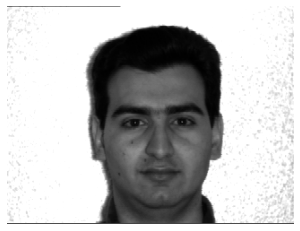

In [17]:
plt.imshow(normalizedimg,cmap="gray")
plt.axis("off")
plt.show()

In [18]:
(img_ndarray.min(),img_ndarray.max())

(0, 255)

## Histogram of Pixel Values of the image

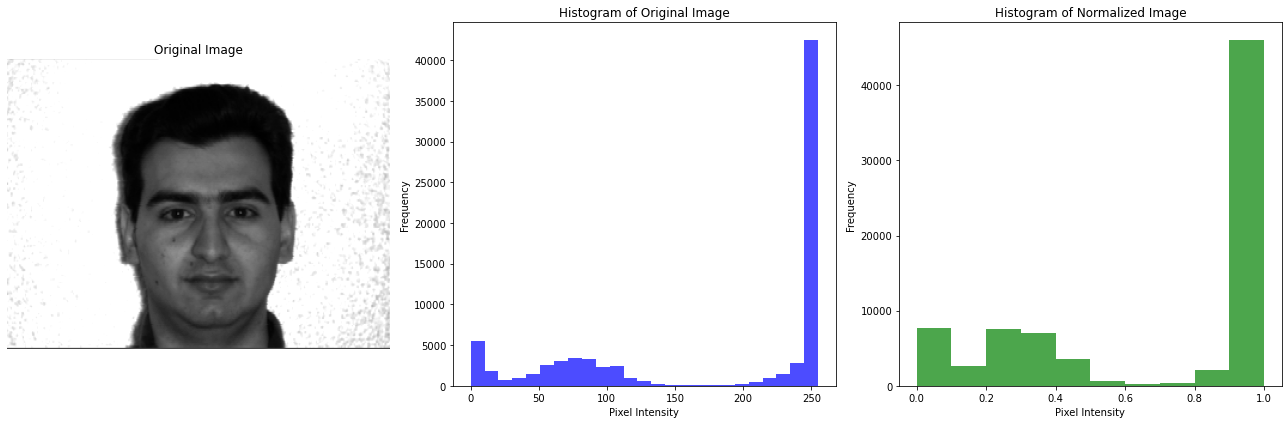

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Display the original image
axes[0].imshow(img_ndarray, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# Histogram of original image
axes[1].hist(img_ndarray.ravel(), bins=25, color='blue', alpha=0.7)
axes[1].set_title("Histogram of Original Image")
axes[1].set_xlabel("Pixel Intensity")
axes[1].set_ylabel("Frequency")

# Histogram of normalized image

axes[2].hist(normalizedimg.ravel(), bins=10, color='green', alpha=0.7)
axes[2].set_title("Histogram of Normalized Image")
axes[2].set_xlabel("Pixel Intensity")
axes[2].set_ylabel("Frequency")

# Show plot
plt.tight_layout()
plt.show()

# Feature Extraction

1. Local Binary Pattern
2. Gabor filter
3. Laplacian of Gaussian (LoG)

## Local Binary Pattern

In [20]:
from skimage.feature import local_binary_pattern
from skimage.transform import rotate
from skimage import data
from skimage.color import label2rgb

Each pixel of an image is labeled with an LBP code
which is obtained by converting the binary code into
decimal one.

In [21]:
# Directories for LBP histograms and full LBP features
lbp_histogram_dir = "/home/iiserb/Desktop/CV_Project/lbp_histogram"
lbp_array_dir = "/home/iiserb/Desktop/CV_Project/lbp_array"
if not os.path.exists(lbp_histogram_dir):
    os.makedirs(lbp_histogram_dir)
if not os.path.exists(lbp_array_dir):
    os.makedirs(lbp_array_dir)

In [22]:
radius = 1
n_points = 8

In [23]:
# Function to extract LBP features as histogram and full LBP array
def lbp_features(image, radius, n_points):
    lbp = local_binary_pattern(image, n_points, radius, method="uniform")
    #uniform method reduces the number of patterns by focusing on those with limited transitions.
# Extract histogram of LBP patterns to make feature vectors comparable, independent of image size.
    n_bins = int(lbp.max() + 1)
    # . ravel(): Flattens the LBP array to a 1D array
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    return lbp, lbp_hist

In [24]:
# Process all files in the normalized_data directory
i=0
for filename in os.listdir(normalized_dir):
    if filename.endswith(".npy"):
        file_path = os.path.join(normalized_dir, filename)
        image = np.load(file_path)

        # Extract LBP features
        lbp, lbp_hist = lbp_features(image, radius = radius, n_points = n_points)

        # Save the LBP histogram
        lbp_hist_path = os.path.join(lbp_histogram_dir, f"{filename}_lbp_hist.npy")
        np.save(lbp_hist_path, lbp_hist)

        # Save the full LBP feature array
        lbp_full_path = os.path.join(lbp_array_dir, f"{filename}_lbp.npy")
        np.save(lbp_full_path, lbp)
        i+=1
        print(f"Processed and saved LBP histogram and full LBP array for {filename}")
print(f"Total {i} files stored")

/home/iiserb/.local/lib/python3.10/site-packages/skimage/feature/texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Processed and saved LBP histogram and full LBP array for subject09.normal.npy
Processed and saved LBP histogram and full LBP array for subject15.rightlight.npy
Processed and saved LBP histogram and full LBP array for subject10.wink.npy
Processed and saved LBP histogram and full LBP array for subject09.sad.npy
Processed and saved LBP histogram and full LBP array for subject04.happy.npy
Processed and saved LBP histogram and full LBP array for subject03.noglasses.npy
Processed and saved LBP histogram and full LBP array for subject03.wink.npy
Processed and saved LBP histogram and full LBP array for subject05.wink.npy
Processed and saved LBP histogram and full LBP array for subject06.surprised.npy
Processed and saved LBP histogram and full LBP array for subject14.noglasses.npy
Processed and saved LBP histogram and full LBP array for subject11.glasses.npy
Processed and saved LBP histogram and full LBP array for subject02.noglasses.npy
Processed and saved LBP histogram and full LBP array for 

Processed and saved LBP histogram and full LBP array for subject15.leftlight.npy
Processed and saved LBP histogram and full LBP array for subject03.rightlight.npy
Processed and saved LBP histogram and full LBP array for subject15.glasses.npy
Processed and saved LBP histogram and full LBP array for subject14.wink.npy
Processed and saved LBP histogram and full LBP array for subject07.normal.npy
Processed and saved LBP histogram and full LBP array for subject10.sad.npy
Processed and saved LBP histogram and full LBP array for subject11.surprised.npy
Processed and saved LBP histogram and full LBP array for subject12.happy.npy
Processed and saved LBP histogram and full LBP array for subject06.noglasses.npy
Processed and saved LBP histogram and full LBP array for subject03.sad.npy
Processed and saved LBP histogram and full LBP array for subject07.leftlight.npy
Processed and saved LBP histogram and full LBP array for subject12.rightlight.npy
Processed and saved LBP histogram and full LBP array

In [25]:
lbp_img = np.load("/home/iiserb/Desktop/CV_Project/lbp_array/subject15.centerlight.npy_lbp.npy")
print(f"The shape of original image is {img_ndarray.shape}")
print(f"The shape of LBP features of an image is {lbp_img.shape}")

The shape of original image is (243, 320)
The shape of LBP features of an image is (243, 320)


The shape of the LBP feature array (243, 320) matches the original image shape because the local_binary_pattern function applies the LBP transformation pixel by pixel, producing an LBP value for each pixel in the image.

In [26]:
lbp_hist = np.load('/home/iiserb/Desktop/CV_Project/lbp_histogram/subject15.centerlight.npy_lbp_hist.npy')

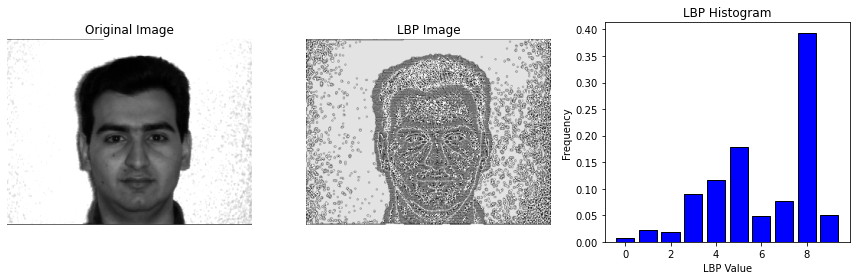

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Display the original image
axes[0].imshow(img_ndarray, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# Display the LBP image
axes[1].imshow(lbp_img, cmap='gray')
axes[1].set_title("LBP Image")
axes[1].axis('off')

n_bins = len(lbp_hist)
axes[2].bar(range(n_bins), lbp_hist, color='blue', edgecolor='black')
axes[2].set_title("LBP Histogram")
axes[2].set_xlabel("LBP Value")
axes[2].set_ylabel("Frequency")


# Show plot
plt.tight_layout()
plt.show()

In [28]:
'''overlay_labels highlights areas with specific LBP values
(representing textures like edges, corners, or flat regions) and helps understand where these patterns appear within the image.
'''

def overlay_labels(image, lbp, labels, alpha=0.5):
  # Create a mask that highlights areas where LBP matches any of the given labels
    mask = np.logical_or.reduce([lbp == each for each in labels])
  # Overlay the mask on the original image with transparency
    return label2rgb(mask, image=image, bg_label=0, alpha=alpha)

In [29]:
def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')

In [30]:
def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(
        lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins), facecolor='0.5'
    )

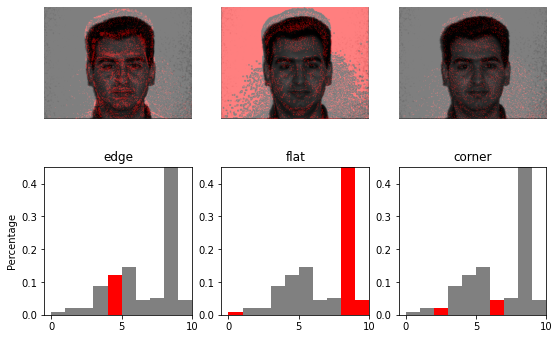

In [31]:
# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1

edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)  # LBP values representing edges

flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))   # Values for flat areas

i_14 = n_points // 4  # 1/4th of the histogram
i_34 = 3 * (n_points // 4)  # 3/4th of the histogram

corner_labels = list(range(i_14 - w, i_14 + w + 1)) + list(
    range(i_34 - w, i_34 + w + 1)
) # Values for corners

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(img_ndarray, lbp, labels, alpha=0.5))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

## Gabor Filter

In [32]:
from skimage.filters import gabor_kernel

In [33]:
# Define parameters
lambdas = [10, 20, 30]  # Wavelengths
thetas = [0, np.pi/4, np.pi/2]  # Orientations
psi = 0    # Phase offset
sigma = 4  # Standard deviation
gamma = 0.5 # Spatial aspect ratio

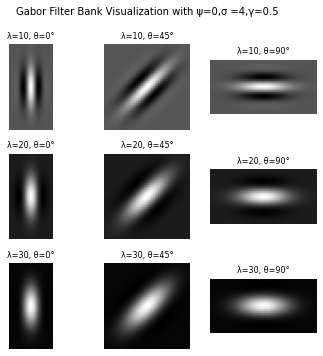

In [34]:
# Create a figure to display the filters
fig, axes = plt.subplots(3, 3, figsize=(5,5))
fig.suptitle(f"Gabor Filter Bank Visualization with ψ={psi},σ ={sigma},γ={gamma}", fontsize=10)

# Loop through each wavelength and orientation to generate and display filters
for i, wavelength in enumerate(lambdas):
    for j, theta in enumerate(thetas):
        gabor_kern = gabor_kernel(frequency=1.0/wavelength, theta=theta, sigma_x=sigma, sigma_y=sigma/gamma, offset=psi)

        # Plot the real part of the Gabor filter
        ax = axes[i, j]
        ax.imshow(np.real(gabor_kern), cmap='gray')
        ax.set_title(f"λ={wavelength}, θ={np.degrees(theta):.0f}°",fontsize=8)
        ax.axis('off')

plt.tight_layout()
plt.show()


In [35]:
def extract_gabor(image, lambdas=lambdas, thetas=thetas,visualize=False):
# Iterates over each combination of wavelength (lambdas) and orientation (thetas).
# For each combination, a Gabor kernel is created using gabor_kernel() with specific parameters for frequency, orientation (theta), and standard deviations (sigma_x and sigma_y).
# The kernel is convolved with the input image using convolve() to get the filtered output.
# The mean and variance of the real part of the convolved image are calculated and appended as features.

    features = []
    conv_results = []  # List to store the convolution results for visualization

    for wavelength in lambdas:
        for theta in thetas:
            gabor_kern = gabor_kernel(frequency=1.0/wavelength,theta=theta, sigma_x=sigma,sigma_y=sigma/gamma,offset=psi)

            # Apply the filter to the image
            conv_result = convolve(image, np.real(gabor_kern))
            conv_results.append(conv_result)  # Store for visualization


            # Extract mean and variance of the filter responses as features
            mean_real = np.mean(conv_result)
            var_real = np.var(conv_result)

            features.append(mean_real)
            features.append(var_real)

    if visualize:
        return np.array(features), conv_results
    else:
        return np.array(features)


In [41]:
gabor_dir = "/home/iiserb/Desktop/CV_Project/gabor_features"
if not os.path.exists(gabor_dir):
    os.makedirs(gabor_dir)

In [42]:
for filename in os.listdir(normalized_dir):
    if filename.endswith(".npy"):
        file_path = os.path.join(normalized_dir, filename)
        image = np.load(file_path)
        gabor_features = extract_gabor(image)

        gabor_save_path = os.path.join(gabor_dir, f"{filename}_gabor.npy")
        np.save(gabor_save_path, gabor_features)

In [44]:
gabor_feature = np.load('/home/iiserb/Desktop/CV_Project/gabor_features/subject15.centerlight.npy_gabor.npy')
print(f"The shape of original image is {img_ndarray.shape}")
print(f"The shape of Gabor Features of the image is {gabor_feature.shape}")

The shape of original image is (243, 320)
The shape of Gabor Features of the image is (18,)


18 values of mean and variance (9 each) for each combination of wavelength and thetas.

For facial recognition, these features provide rich information about the spatial frequency and directionality of face textures, making them robust to variations in lighting and facial orientation.

For a Gabor filter with a specific orientation (say 45°) and frequency, the mean might tell you how strong the edges are in that direction (e.g., how prominent the facial features like the jawline or cheekbones are).

The variance could tell you how much variability or detail exists along that edge (e.g., smooth jawline vs. a more detailed texture in the region of wrinkles).

### Visualize

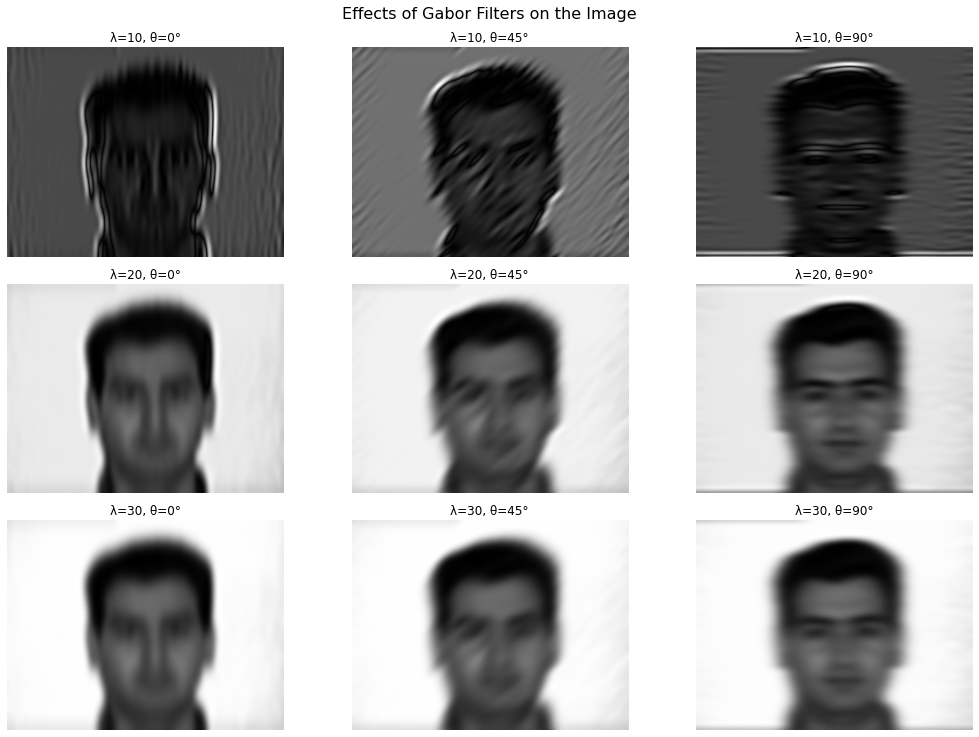

In [66]:
_, gabor_imgs = extract_gabor(normalizedimg, visualize=True)

# Visualize all the filtered results
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
lambdas = [10, 20, 30]
thetas = [0, np.pi/4, np.pi/2]

for i, ax in enumerate(axes.flat):
    ax.imshow(np.abs(gabor_imgs[i]), cmap='gray')
    wavelength = lambdas[i // 3]
    theta = thetas[i % 3]
    ax.set_title(f"λ={wavelength}, θ={np.degrees(theta):.0f}°")
    ax.axis('off')

# Adjust layout for better visualization
plt.tight_layout()
plt.suptitle("Effects of Gabor Filters on the Image", fontsize=16, y=1.02)
plt.show()


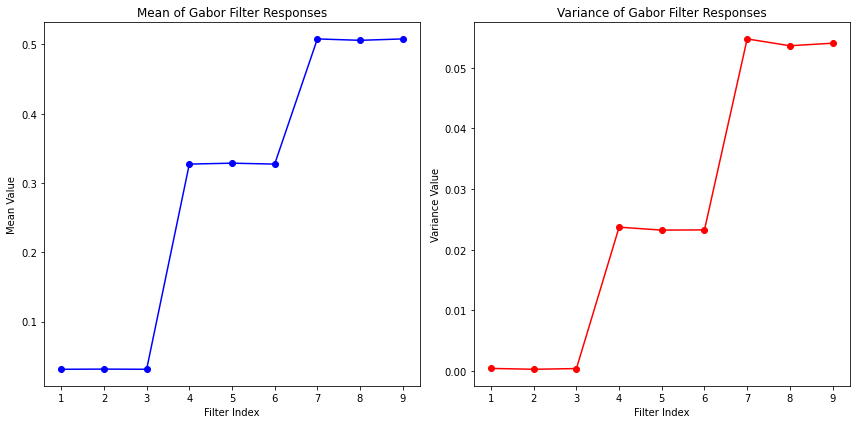

In [67]:
# Assuming each Gabor filter output was summarized by its mean and variance
num_filters = len(gabor_features) // 2  # Dividing by 2 because each filter has mean and variance
means = gabor_features[::2]
variances = gabor_features[1::2]

# Create x indices starting from 1
x_indices = range(1, num_filters + 1)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plotting means as a line plot
ax[0].plot(x_indices, means, marker='o', linestyle='-', color='b')
ax[0].set_title("Mean of Gabor Filter Responses")
ax[0].set_xlabel("Filter Index")
ax[0].set_ylabel("Mean Value")
ax[0].set_xticks(x_indices)  # Display all integer values on x-axis

# Plotting variances as a line plot
ax[1].plot(x_indices, variances, marker='o', linestyle='-', color='r')
ax[1].set_title("Variance of Gabor Filter Responses")
ax[1].set_xlabel("Filter Index")
ax[1].set_ylabel("Variance Value")
ax[1].set_xticks(x_indices)  # Display all integer values on x-axis

plt.tight_layout()
plt.show()


## **Laplacian of Gaussian (LoG)**

In [68]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Directory where the original .npy files are stored
data_dir = "/home/iiserb/Desktop/CV_Project/normalized_data"
# Directory to save the transformed .npy files
log_dir = "/home/iiserb/Desktop/CV_Project/LoG_transformed"
os.makedirs(log_dir, exist_ok=True)

# List all .npy files in the directory
npy_files = [f for f in os.listdir(data_dir) if f.endswith('.npy')]


# Function to apply Laplacian of Gaussian (LoG) transformation
def laplacian_of_gaussian(image, kernel_size=3):
    # Convert the image to CV_64F before applying GaussianBlur
    blurred_image = cv2.GaussianBlur(image.astype(np.float64), (kernel_size, kernel_size), 0)
    log_image = cv2.Laplacian(blurred_image, cv2.CV_64F)
    return log_image

# Process and save each image
for file_name in npy_files:
    # Load the .npy file
    image_path = os.path.join(data_dir, file_name)
    image = np.load(image_path)

    # apply LoG transformation
    log_image = laplacian_of_gaussian(image)

    # Save the transformed image as a new .npy file
    transformed_path = os.path.join(log_dir, file_name)
    np.save(transformed_path, log_image)
    print(f"Transformed and saved: {transformed_path}")

Transformed and saved: /home/iiserb/Desktop/CV_Project/LoG_transformed/subject09.normal.npy
Transformed and saved: /home/iiserb/Desktop/CV_Project/LoG_transformed/subject15.rightlight.npy
Transformed and saved: /home/iiserb/Desktop/CV_Project/LoG_transformed/subject10.wink.npy
Transformed and saved: /home/iiserb/Desktop/CV_Project/LoG_transformed/subject09.sad.npy
Transformed and saved: /home/iiserb/Desktop/CV_Project/LoG_transformed/subject04.happy.npy
Transformed and saved: /home/iiserb/Desktop/CV_Project/LoG_transformed/subject03.noglasses.npy
Transformed and saved: /home/iiserb/Desktop/CV_Project/LoG_transformed/subject03.wink.npy
Transformed and saved: /home/iiserb/Desktop/CV_Project/LoG_transformed/subject05.wink.npy
Transformed and saved: /home/iiserb/Desktop/CV_Project/LoG_transformed/subject06.surprised.npy
Transformed and saved: /home/iiserb/Desktop/CV_Project/LoG_transformed/subject14.noglasses.npy
Transformed and saved: /home/iiserb/Desktop/CV_Project/LoG_transformed/subjec

The code applies Laplacian of Gaussian(LoG), and then stores all the transformed images in the folder named as "LoG_transformed".

### **Some code to display the output, inshort display the "LoG_transformed" images**.

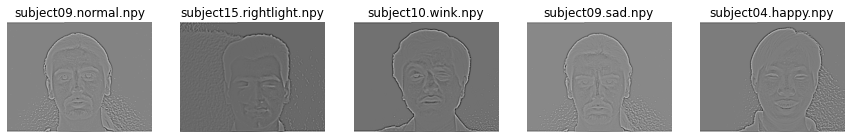

In [69]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Directory where the LoG transformed .npy files are saved
log_dir = "/home/iiserb/Desktop/CV_Project/LoG_transformed"

# List all .npy files in the LoG transformed directory
log_files = [f for f in os.listdir(log_dir) if f.endswith('.npy')]

# Number of images to display
num_images_to_display = 5

# Set up a horizontal subplot
plt.figure(figsize=(15, 5))  # Adjust width and height as needed

for i, file_name in enumerate(log_files[:num_images_to_display]):
    # Load the transformed .npy file
    log_image_path = os.path.join(log_dir, file_name)
    log_image = np.load(log_image_path)

    # Add subplot in a 1x5 grid (1 row, 5 columns)
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(log_image, cmap='gray')
    plt.title(file_name)
    plt.axis('off')

plt.show()

# Merging all the feature vectors.

In [70]:
import numpy as np
import pandas as pd

# Load features
log_features = np.load('/home/iiserb/Desktop/CV_Project/LoG_transformed/subject15.centerlight.npy')
gabor_features = np.load('/home/iiserb/Desktop/CV_Project/gabor_features/subject15.centerlight.npy_gabor.npy')
lbp_features = np.load('/home/iiserb/Desktop/CV_Project/lbp_array/subject15.centerlight.npy_lbp.npy')

# Reshape gabor_features to have 2 dimensions
gabor_features = gabor_features.reshape(1, -1)  # Reshape to (1, number_of_gabor_features)

# Concatenate features along the second axis (feature axis)
# Since log_features and lbp_features have the same shape, concatenate them first
image_features = np.concatenate((log_features, lbp_features), axis=0) #This is done to merge log and lbp as they have compatible shapes

#Now, since these features are image level features (243,320) each, and gabor features are image-level features
#we need to perform flattening
flattened_image_features= image_features.flatten() #Reshape into (243*320,)
#Reshape gabor and glcm into 1D as well
flattened_gabor_features = gabor_features.flatten()

# Change axis to 0 for concatenation of 1-D arrays
combined_features = np.concatenate((flattened_image_features, flattened_gabor_features), axis=None) #Concatenate all into 1D feature vector

In [71]:
label = []
for filename in sorted(os.listdir("/home/iiserb/Desktop/CV_Project/LoG_transformed")):
    if filename.endswith('.npy'):
        names = filename.split('.')
        l = names[0][7:]
        l = int(l)
        label.append(l)

In [72]:
np.array(label)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15])

In [73]:
# Define the path to save the label list
output_dir = "/home/iiserb/Desktop/CV_Project/label"
os.makedirs(output_dir, exist_ok=True)
label_path = os.path.join(output_dir, "labels.npy")

# Save the list of labels as a NumPy array
np.save(label_path, np.array(label))

print(f"Saved all labels to {label_path}")

Saved all labels to /home/iiserb/Desktop/CV_Project/label/labels.npy


In [74]:
gabor_features = np.load('/home/iiserb/Desktop/CV_Project/gabor_features/subject15.centerlight.npy_gabor.npy')
gabor_features

array([3.0540859e-02, 4.4390018e-04, 3.0804465e-02, 2.9368451e-04,
       3.0540856e-02, 4.2728265e-04, 3.2000962e-01, 2.6815457e-02,
       3.2131448e-01, 2.5911862e-02, 3.2000965e-01, 2.5447074e-02,
       4.9660534e-01, 6.2354647e-02, 4.9462402e-01, 6.0335457e-02,
       4.9660534e-01, 6.0007021e-02], dtype=float32)

In [75]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score


In [76]:
# Paths to each subfolder
base_folder = '/home/iiserb/Desktop/CV_Project'
log_path = os.path.join(base_folder, 'LoG_transformed')
gabor_path = os.path.join(base_folder, 'gabor_features')
glcm_path = os.path.join(base_folder, 'glcm_features')
lbp_path = os.path.join(base_folder, 'lbp_histogram')

# Initialize lists to store combined features and labels
combined_features = []
labels = []

# Define placeholder sizes for missing features if necessary
log_placeholder = np.zeros((50,))       # Replace 50 with actual feature size if known
gabor_placeholder = np.zeros((80,))     # Replace 80 with actual feature size if known
glcm_placeholder = np.zeros((30,))      # Replace 30 with actual feature size if known
lbp_placeholder = np.zeros((60,))       # Replace 60 with actual feature size if known

# Load and combine features based on filenames
for filename in os.listdir(log_path):
    # Extract base name and label
    base_name = filename.replace('.npy', '')
    label = base_name.split('.')[0]  # Assuming "subject01" is the label

    # Load and flatten LoG features
    log_features = np.load(os.path.join(log_path, filename)).flatten() if os.path.exists(os.path.join(log_path, filename)) else log_placeholder

    # Load and flatten Gabor features with updated filename pattern
    gabor_filename = f"{base_name}.npy_gabor.npy"
    gabor_features = np.load(os.path.join(gabor_path, gabor_filename)).flatten() if os.path.exists(os.path.join(gabor_path, gabor_filename)) else gabor_placeholder

    # Load and flatten GLCM features from CSV
    glcm_filename = f"{base_name}_features.csv"
    if os.path.exists(os.path.join(glcm_path, glcm_filename)):
        glcm_df = pd.read_csv(os.path.join(glcm_path, glcm_filename))
        glcm_features = glcm_df.values.flatten()
    else:
        glcm_features = glcm_placeholder

    # Load and flatten LBP features
    lbp_filename = f"{base_name}.npy_lbp.npy"
    lbp_features = np.load(os.path.join(lbp_path, lbp_filename)).flatten() if os.path.exists(os.path.join(lbp_path, lbp_filename)) else lbp_placeholder

    # Concatenate all features for this image
    combined_feature_vector = np.concatenate((log_features, gabor_features, glcm_features, lbp_features))
    combined_features.append(combined_feature_vector)
    labels.append(label)

# Convert lists to arrays
combined_features = np.array(combined_features)
labels = np.array(labels)

In [77]:
combined_features.shape

(165, 77868)

In [78]:
print(f"The dimension of feature vector : {combined_features.shape}")
print(f"The number of features from LBP:{lbp_features.shape}")
print(f"The number of features from GLCM:{glcm_features.shape}")
print(f"The number of features from Gabor:{gabor_features.shape}")
print(f"The number of features from LoG:{log_features.shape}")
print(f"The total number of features: {lbp_features.shape[0]+glcm_features.shape[0]+gabor_features.shape[0]+log_features.shape[0]}")

The dimension of feature vector : (165, 77868)
The number of features from LBP:(60,)
The number of features from GLCM:(30,)
The number of features from Gabor:(18,)
The number of features from LoG:(77760,)
The total number of features: 77868


In [79]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_features, labels, test_size=0.3, random_state=42)

### STANDARIZATION

In [80]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### APPLYING PCA

In [81]:
# Apply PCA to reduce dimensions
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [82]:
y_test_df = pd.DataFrame(y_test)

# Get unique values from the entire DataFrame
pd.unique(y_test_df.values.ravel())

array(['subject06', 'subject11', 'subject10', 'subject03', 'subject01',
       'subject15', 'subject13', 'subject02', 'subject09', 'subject07',
       'subject04', 'subject14', 'subject12', 'subject05', 'subject08'],
      dtype=object)

In [83]:
print(f"The dimension of feature vector before transformation: {X_train.shape}")
print(f"The dimension of feature vector after transformation: {X_train_pca.shape}")
print(f"The number of features dropped by PCA: {(X_train.shape)[1]-(X_train_pca.shape)[1]}")

The dimension of feature vector before transformation: (115, 77868)
The dimension of feature vector after transformation: (115, 88)
The number of features dropped by PCA: 77780


## APPLYING Support Vector Classifier(SVC)

In [84]:
# Define parameter grid for SVC
param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 1],
    'kernel': ['linear', 'rbf', 'poly'],
}

#### SVC USING THE DIMENSIONAL REDUCTION

In [85]:
# Initialize SVC
svc = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(svc, param_grid_svc, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_pca, y_train)


# Print best parameters found
print(f"Best parameters: {grid_search.best_params_}")

# Use the best estimator found by grid search
best_svc = grid_search.best_estimator_

# Predict on the test set
y_pred = best_svc.predict(X_test_pca)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized classification accuracy after PCA for SVC: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Optimized classification accuracy after PCA for SVC: 42.00%
Classification Report:
               precision    recall  f1-score   support

   subject01       0.00      0.00      0.00         6
   subject02       1.00      1.00      1.00         4
   subject03       0.07      1.00      0.12         2
   subject04       1.00      0.67      0.80         3
   subject05       1.00      0.67      0.80         3
   subject06       1.00      1.00      1.00         2
   subject07       1.00      0.33      0.50         3
   subject08       0.00      0.00      0.00         3
   subject09       0.00      0.00      0.00         3
   subject10       1.00      0.50      0.67         4
   subject11       1.00      0.50      0.67         2
   subject12       1.00      0.60      0.75         5
   subject13       0.00      0.00      0.00         5
   subject14       1.00      0.50  

/home/iiserb/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iiserb/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iiserb/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### SVC ON ORIGINAL FEATURE VECTOR

In [86]:
# Train classifier
classifier = SVC()
classifier.fit(X_train, y_train)

# Test and evaluate
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Classification accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification accuracy: 58.00%
Classification Report:
               precision    recall  f1-score   support

   subject01       0.00      0.00      0.00         6
   subject02       1.00      1.00      1.00         4
   subject03       0.00      0.00      0.00         2
   subject04       1.00      0.67      0.80         3
   subject05       1.00      0.67      0.80         3
   subject06       1.00      1.00      1.00         2
   subject07       0.19      1.00      0.32         3
   subject08       0.50      0.33      0.40         3
   subject09       0.00      0.00      0.00         3
   subject10       1.00      0.50      0.67         4
   subject11       0.67      1.00      0.80         2
   subject12       1.00      0.60      0.75         5
   subject13       1.00      0.80      0.89         5
   subject14       0.29      1.00      0.44         2
   subject15       0.67      0.67      0.67         3

    accuracy                           0.58        50
   macro avg       0.62 

/home/iiserb/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iiserb/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iiserb/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [87]:
# Initialize SVC
svc = SVC()

# Perform grid search with cross-validation
grid_search = GridSearchCV(svc, param_grid_svc, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Print best parameters found
print(f"Best parameters: {grid_search.best_params_}")

# Use the best estimator found by grid search
best_svc = grid_search.best_estimator_

# Predict on the test set
y_pred = best_svc.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized classification accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Optimized classification accuracy: 76.00%
Classification Report:
               precision    recall  f1-score   support

   subject01       1.00      0.50      0.67         6
   subject02       0.80      1.00      0.89         4
   subject03       0.00      0.00      0.00         2
   subject04       1.00      1.00      1.00         3
   subject05       1.00      0.67      0.80         3
   subject06       0.67      1.00      0.80         2
   subject07       0.33      1.00      0.50         3
   subject08       1.00      0.33      0.50         3
   subject09       1.00      0.33      0.50         3
   subject10       1.00      0.75      0.86         4
   subject11       1.00      1.00      1.00         2
   subject12       1.00      0.80      0.89         5
   subject13       1.00      1.00      1.00         5
   subject14       1.00      1.00      1.00      

## APPLYING Logistic Regression 

In [91]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

param_grid_lr = {
    'C': [0.1, 1, 10],        
    'penalty': ['l1', 'l2'], 
    'solver': ['liblinear'], 
    'max_iter': [100] }

# Initialize Logistic Regression and perform GridSearchCV
lr = LogisticRegression()
grid_search_lr = GridSearchCV(
    lr,
    param_grid_lr,
    cv=3,            
    n_jobs=-1,        
    verbose=1       
)

# Fit the model on the PCA-transformed training data
grid_search_lr.fit(X_train_pca, y_train)

# Print best parameters found
print(f"Best parameters for Logistic Regression: {grid_search_lr.best_params_}")

# Use the best estimator to predict on the test set
best_lr = grid_search_lr.best_estimator_
y_pred = best_lr.predict(X_test_pca)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized classification accuracy after PCA: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters for Logistic Regression: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Optimized classification accuracy after PCA: 66.00%
Classification Report:
               precision    recall  f1-score   support

   subject01       0.00      0.00      0.00         6
   subject02       1.00      1.00      1.00         4
   subject03       0.00      0.00      0.00         2
   subject04       0.75      1.00      0.86         3
   subject05       0.67      0.67      0.67         3
   subject06       1.00      1.00      1.00         2
   subject07       0.67      0.67      0.67         3
   subject08       0.50      0.33      0.40         3
   subject09       1.00      0.33      0.50         3
   subject10       0.60      0.75      0.67         4
   subject11       0.67      1.00      0.80         2
   subject12       1.00      0.80      0.89         5
   subject13       0.62      1.00      0.77         

/home/iiserb/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/iiserb/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/iiserb/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/iiserb/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [90]:
# Train Logistic Regression without PCA (for comparison)
lr_no_pca = LogisticRegression(max_iter=100)
lr_no_pca.fit(X_train, y_train)

y_pred_no_pca = lr_no_pca.predict(X_test)
accuracy_no_pca = accuracy_score(y_test, y_pred_no_pca)
print(f"Classification accuracy without PCA: {accuracy_no_pca * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, y_pred_no_pca))

Classification accuracy without PCA: 80.00%
Classification Report:
               precision    recall  f1-score   support

   subject01       1.00      0.67      0.80         6
   subject02       0.80      1.00      0.89         4
   subject03       0.00      0.00      0.00         2
   subject04       1.00      1.00      1.00         3
   subject05       1.00      0.67      0.80         3
   subject06       0.67      1.00      0.80         2
   subject07       0.43      1.00      0.60         3
   subject08       1.00      0.33      0.50         3
   subject09       1.00      0.33      0.50         3
   subject10       1.00      0.75      0.86         4
   subject11       0.67      1.00      0.80         2
   subject12       1.00      1.00      1.00         5
   subject13       1.00      1.00      1.00         5
   subject14       1.00      1.00      1.00         2
   subject15       0.60      1.00      0.75         3

    accuracy                           0.80        50
   macro avg